<a href="https://colab.research.google.com/github/samvaadi/AI-ML/blob/main/BSRGAN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title ##**Install** { display-mode: "form" }
%%capture
!nvidia-smi
!git clone https://github.com/cszn/BSRGAN.git
%cd BSRGAN


!pip install scikit-image pyyaml tqdm gdown

import os
if not os.path.exists('model_zoo'):
    os.makedirs('model_zoo')


#!gdown --id 1WNULM1e8gRNvsngVscsQ8tpaOqJ4mYtv -O model_zoo/BSRGAN.pth



In [4]:
#@title ##**Upload images** { display-mode: "form" }
from google.colab import files
import os
import shutil
from tqdm import tqdm
import os
import shutil, sys

upload_folder = '/content/BSRGAN/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.makedirs(upload_folder)

uploaded = files.upload()


for filename in uploaded.keys():
    with open(os.path.join(upload_folder, filename), 'wb') as f:
        f.write(uploaded[filename])

print(f"Images have been uploaded to {upload_folder}")


Saving sample_pic_imresizer.jpg to sample_pic_imresizer.jpg
Images have been uploaded to /content/BSRGAN/upload


In [13]:
#@title ##**Run** { display-mode: "form" }
import os
import torch
import shutil
import time
from utils import utils_image as util
from models.network_rrdbnet import RRDBNet as net



model_ids = {
    "BSRGAN": "1WNULM1e8gRNvsngVscsQ8tpaOqJ4mYtv",
    "BSRGANx2": "1J-6NX3DB6GA0G8AN95vmgWs_2l9l4dJf",
    "BSRNet": "1JGJLiENPkOqi39bvQYa_jlIPlMk24iKH"
}

scale = "4"
selected_model = "BSRGAN"

upload_folder = '/content/BSRGAN/upload'
result_folder = '/content/BSRGAN/results'

if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.makedirs(result_folder)

if selected_model in model_ids:
    model_path = f'model_zoo/{selected_model}.pth'

    if not os.path.exists(model_path):
        model_id = model_ids[selected_model]
        !gdown --id {model_id} -O {model_path}

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sf = int(scale)
    model = net(in_nc=3, out_nc=3, nf=64, nb=23, gc=32, sf=sf)
    model.load_state_dict(torch.load(model_path), strict=True)
    model.eval()
    for k, v in model.named_parameters():
        v.requires_grad = False
    model = model.to(device)

    start_time = time.time()
    for filename in os.listdir(upload_folder):
        img_path = os.path.join(upload_folder, filename)
        img_L = util.imread_uint(img_path, n_channels=3)
        img_L = util.uint2tensor4(img_L)
        img_L = img_L.to(device)

        with torch.no_grad():
            img_E = model(img_L)

        img_E = util.tensor2uint(img_E)

        output_image_name = os.path.splitext(filename)[0] + f'_{selected_model}.png'
        util.imsave(img_E, os.path.join(result_folder, output_image_name))
        end_time = time.time() # Record the end time
    inference_time = end_time - start_time # Calculate the elapsed time


    print(f"Total inference time: {inference_time:.2f} seconds")

    print(f"Images have been processed and saved to {result_folder}")
else:
    print("Selected model is not available.")

[3, 3, 64, 23, 32, 4]
Total inference time: 0.69 seconds
Images have been processed and saved to /content/BSRGAN/results


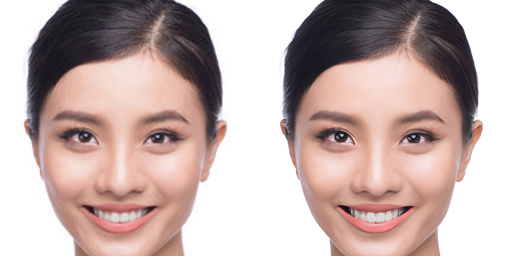

In [7]:
#@title ##**Visualize** { display-mode: "form" }
from PIL import Image
import numpy as np
import os
from IPython.display import display

filenames_upload = os.listdir(upload_folder)
filenames_upload.sort()

filenames_upload_output = os.listdir(result_folder)
filenames_upload_output.sort()

for filename, filename_output in zip(filenames_upload, filenames_upload_output):
    image_original = Image.open(os.path.join(upload_folder, filename))
    image_restore = Image.open(os.path.join(result_folder, filename_output))

    # Get the original height and width of both images
    width_original, height_original = image_original.size
    width_restore, height_restore = image_restore.size

    # Determine the target height for both images (use the smaller height)
    target_height = min(height_original, height_restore)

    # Resize both images to the target height, maintaining aspect ratio
    # Calculate the new width based on the target height
    new_width_original = int(width_original * target_height / height_original)
    new_width_restore = int(width_restore * target_height / height_restore)

    image_original_resized = image_original.resize((new_width_original, target_height))
    image_restore_resized = image_restore.resize((new_width_restore, target_height))


    # Display the horizontally stacked images
    display(Image.fromarray(np.hstack((np.array(image_original_resized), np.array(image_restore_resized)))))
    print("")

In [ ]:
#@title ##**Download results** { display-mode: "form" }
#output_folder = os.path.join(upload_output_path, "final_output")
files_in_folder = os.listdir(result_folder)
zip_file = "download.zip"

if len(files_in_folder) == 1:
    file_to_download = os.path.join(result_folder, files_in_folder[0])
    files.download(file_to_download)
else:
    if os.path.exists(os.path.join(result_folder, zip_file)):
      os.remove(os.path.join(result_folder, zip_file))
    os.system(f"cd {result_folder} && zip -r -j {zip_file} * && cd ..")
    files.download(os.path.join(result_folder, zip_file))